In [1]:
import emoji
import numpy as np
import pandas as pd

import glob
import re

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_rows = 400

In [4]:
data_path = './data'

def read_csvs(data_path):
    all_files = glob.glob(data_path + "/*.csv")

    df_list = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=0)
        df_list.append(df)

    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df

In [5]:
df = read_csvs(data_path)
df.head()

,text,created_at,id,retweet_count,reply_count,like_count,quote_count,hashtags
0,Waterloo region: Free Rapid Antigen Screening ...,2021-09-23T20:27:02.000Z,1441137048421687300,16,1,31,2,[]
1,Kitchener - Cambridge - Stratford: Free Rapid ...,2021-09-23T20:57:11.000Z,1441144639210197002,3,0,8,1,[]
2,Ontario Businesses with &lt; 150 Employees: Fr...,2021-09-23T21:23:52.000Z,1441151353372307457,10,0,16,1,[]
3,"Ontario High-Risk Communities, Organizations a...",2021-09-23T21:25:48.000Z,1441151840633057287,4,1,11,2,[]
4,"Ontario, Manitoba, Saskatchewan, and Alberta: ...",2021-09-23T23:22:56.000Z,1441181317455126529,15,1,16,0,[]


In [6]:
def clean_hashtags(df):
    """
    Cleans a column labelled 'raw_hashtags', which contains a list of strings.
    Converts to lowercase, strips punctuation, and removes emojis.
    Returns dataframe with original column renamed to 'raw_hashtags'.
    """
    if df is not None:
        hashtag_df = df[['raw_hashtags']].applymap(lambda x: [h.lower() for h in x])
        hashtag_df = hashtag_df.applymap(lambda x: [re.sub(r'[^\w\s]+', '', h) for h in x])
        hashtag_df = hashtag_df.applymap(lambda x: [emoji.get_emoji_regexp().sub("", h) for h in x])
        hashtag_df = hashtag_df.rename(columns = {'raw_hashtags': 'clean_hashtags'})
        df = pd.concat([df, hashtag_df], axis=1)
    return df


def clean_data(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['raw_hashtags'] = df['hashtags'].apply(eval).tolist()
    df = df.drop(columns=['hashtags'])
    df = clean_hashtags(df)
    return df

In [7]:
clean_df = clean_data(df)
clean_df.tail()

,text,created_at,id,retweet_count,reply_count,like_count,quote_count,raw_hashtags,clean_hashtags
1625,Updates on RATs related to Omicron:\n\n- use s...,2022-01-05 16:16:47+00:00,1478762411033301003,53,6,101,4,[],[]
1626,@RunWaterloo @AnthonyJoch #ctfWaterlooRATs rap...,2022-01-05 16:18:00+00:00,1478762715632082949,0,1,1,0,[#ctfWaterlooRATs],[ctfwaterloorats]
1627,[BC] Vancouver: 🆓 2-pack of RATs at City Centr...,2022-01-05 20:52:03+00:00,1478831683143012353,5,1,8,1,[#ctfBC],[ctfbc]
1628,Now is the time for the provincial governments...,2022-01-05 20:58:29+00:00,1478833301473402881,24,5,76,0,[#FreeTheRATs],[freetherats]
1629,Rapid antigen tests have never been a problem ...,2022-01-05 21:03:51+00:00,1478834655528894464,32,11,109,3,[#FreeTheRATs❓❔],[freetherats]


In [8]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

print(to_1D(clean_df["clean_hashtags"]).value_counts())

freetherats                     458
rapidtests                      165
rapidkits4kids                   79
rapidtest                        45
testtoprotect                    39
testtraceisolate                 23
ctfns                            20
ctfkitchenerrats                 18
ctfbc                            18
ctftorontorats                   15
3dosesnow                        14
onpoli                           13
ventilate2educate                12
ctfon                            12
ctfottawarats                    12
rapidkits4all                    12
longcovid                        11
ctfsk                            11
shoppersdougmart                 11
ctfmississaugarats                9
rapidtesting                      9
covidisairborne                   9
ctfnepeanrats                     9
ctfhamiltonrats                   9
vaxtothemax                       8
gatornation                       8
covid19bc                         7
thisisourshotca             

<AxesSubplot:>

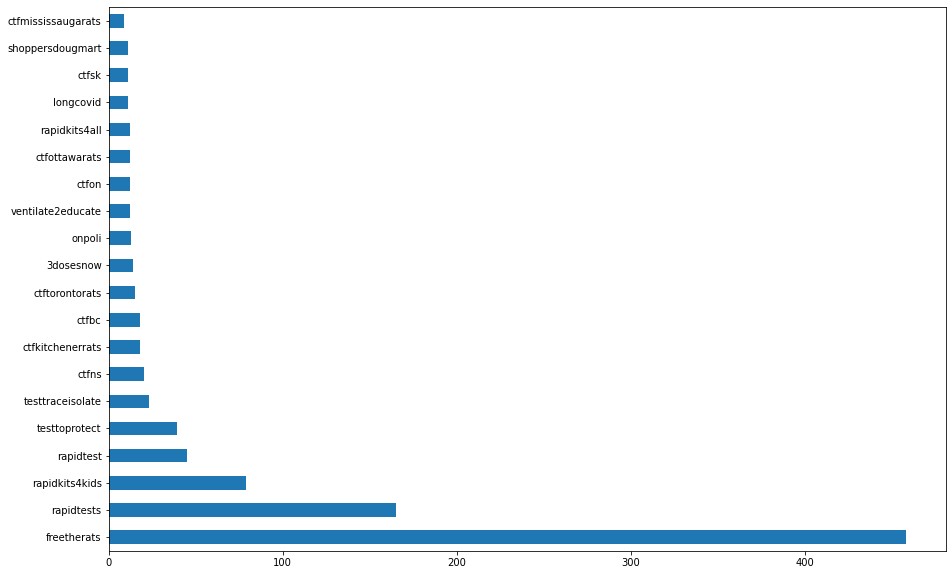

In [9]:
to_1D(clean_df["clean_hashtags"]).value_counts().head(20).plot(kind='barh', figsize=(15,10))

In [10]:
clean_df.loc[:,['text', 'clean_hashtags']].tail(20).style.set_properties(subset=['text'], **{'width': '300px'})

,text,clean_hashtags
1610,https://t.co/M6q3VjaXe7,[]
1611,"Ontario: 5⃣🆓 RATs will be distributed Wednesday, Jan. 5th at the following pop-ups: #ctfOttawaRATs #ctfThunderBayRATs #ctfNoelvilleRATs #ctfPetersboroughRATs #ctfScarboroughRATs #ctfWaterlooRATs Don't forget to use the above hashtags to search for or post updates https://t.co/HAA1osxCmp","['ctfottawarats', 'ctfthunderbayrats', 'ctfnoelvillerats', 'ctfpetersboroughrats', 'ctfscarboroughrats', 'ctfwaterloorats']"
1612,"@nedan66 Not this week, you can monitor: https://t.co/Rw8hhQqUfG",[]
1613,"Nova Scotia: Rapid testing and limited 🆓 RATs available in Halifax, Dartmouth, Windsor, and Bridgetown Wednesday, January 5th For more information (including volunteer applications!) visit: https://t.co/6tA4eDbfkv #ctfNS https://t.co/dXbqJO7kwn",['ctfns']
1614,@CFifeKW @LauraMaeLindo @ChildCareON @OPSBA You covered everything that’s needed for a safe return back to school. Thank you for your leadership 👏🏻 https://t.co/gd0i5g5C0L,[]
1615,"RT @C19TestFinders: Nova Scotia: Rapid testing and limited 🆓 RATs available in Halifax, Dartmouth, Windsor, and Bridgetown Wednesday, Janua…",[]
1616,"RT @C19TestFinders: Ontario: 5⃣🆓 RATs will be distributed Wednesday, Jan. 5th at the following pop-ups: #ctfOttawaRATs #ctfThunderBayRATs…","['ctfottawarats', 'ctfthunderbayrats']"
1617,@CanadaEhOui @bhubahib If you are still positive after the end of 5 days you would need to continue isolating until you have 2 negative RATs in 24 hrs. We are continuing to advocate to #FreeTheRATs to make testing accessible. Here are some things you can do in Ontario to help: https://t.co/cGtSRcFS3E,['freetherats']
1618,"@drmwarner @ONgov Help us keep our children and school staff safe by urging the @ONgov to #FreeTheRATs in a safe, equitable and accessible way https://t.co/cGtSRcFS3E",['freetherats']
1619,"Help us keep our children and school staff safe 🏫❤️ Below are links which lead to province-specific: 📝Petitions ☎️ Premier offices contact information which will help us urge the provincial governments to #FreeTheRATs in a safe, equitable and accessible way https://t.co/hJXKhshKGj",['freetherats']


In [11]:
# Checking tweets associated with specific hashtags
def tweet_lookup_by_hashtag(df, hashtag):
    df['mask_col'] = df['clean_hashtags'].apply(lambda x: hashtag_of_interest in x)
    mask = df['mask_col'] == True
    return df[mask].loc[:,['text', 'clean_hashtags']].style.set_properties(subset=['text'], **{'width': '400px'})


    
hashtag_of_interest = 'staysafeambassador'
tweet_lookup_by_hashtag(clean_df, hashtag_of_interest)

,text,clean_hashtags
36,@bradhopper14 This account has been created to share how 🇨🇦 can acquire #rapidtests through initiatives such as the #StaySafeAmbassador program. We wish you the best of luck with your application - and feel free to keep us posted on your submission results,"['rapidtests', 'staysafeambassador']"
37,@bradhopper14 This account has been created to share how 🇨🇦 can acquire #rapidtests through initiatives such as the #StaySafeAmbassador program. We wish you the best of luck with your application - and feel free to keep us posted on your submission results,"['rapidtests', 'staysafeambassador']"


In [20]:
clean_df['mask_col'] = clean_df['clean_hashtags'].apply(lambda x: len(x) < 1)
mask = clean_df['mask_col'] == True
clean_df[mask].loc[:,['text', 'id', 'created_at']].style.set_properties(subset=['text'], **{'width': '600px'})

,text,id,created_at
0,Waterloo region: Free Rapid Antigen Screening Testing https://t.co/RrhBTpMNF7 https://t.co/HVr1JEMgeb,1441137048421687300,2021-09-23 20:27:02+00:00
1,Kitchener - Cambridge - Stratford: Free Rapid Antigen Screening Test Kits for Businesses < 150 Employees https://t.co/89RAQazQLK https://t.co/rHJ6OpJBrf,1441144639210197002,2021-09-23 20:57:11+00:00
2,Ontario Businesses with < 150 Employees: Free Rapid Antigen Screening Test Kits https://t.co/gQ7KHFzs5p https://t.co/S0t3QIm13D,1441151353372307457,2021-09-23 21:23:52+00:00
3,"Ontario High-Risk Communities, Organizations and Workplaces (>150 employees): Free Rapid Antigen Screening Test Kits https://t.co/RoDAnRa66A https://t.co/jWCEkOvS05",1441151840633057287,2021-09-23 21:25:48+00:00
4,"Ontario, Manitoba, Saskatchewan, and Alberta: Businesses with 10 - 199 High-Contact Critical Employees: Free Rapid Antigen Screening Test Kits https://t.co/8utJ6f9uNX https://t.co/5j8WbY3cw4",1441181317455126529,2021-09-23 23:22:56+00:00
5,"@vickyyyf Agreed! Our account has been created to identify where the public can find a walk-in or pop-up to be rapidly tested, and also for businesses to register for free test kits https://t.co/8iaNbEwhVF",1441183956771082242,2021-09-23 23:33:25+00:00
6,@BogochIsaac @RegionWaterloo We applaud such initiatives and have created our account to highlight these life-saving programs. @C19TestFinders is focused to share where the public can find free easily accessible testing,1441190558739812352,2021-09-23 23:59:39+00:00
7,@timalamenciak @RegionWaterloo @Communitech That must be such a relief! Our account has been created to highlight such initiatives and help the public access rapid COVID tests as needed,1441191536356696064,2021-09-24 00:03:32+00:00
8,"@RegionWaterloo @NSF_Intl @My_Chamber @GKWCC This is a wonderful initiative to advance public health. Our account was created to share COVID rapid testing programs, pop-ups, and walk-ins so they may be accessible to whoever needs them.",1441193079093055488,2021-09-24 00:09:40+00:00
9,@margjohnst @GKWCC @My_Chamber @RoWEcDev Our twitter account is committed to sharing such life-saving initiatives so that the public may know how to access rapid COVID tests across our province.,1441193354956398600,2021-09-24 00:10:46+00:00


In [12]:
# Testing regular expressions to categorize tweets based on text
foo = clean_df.loc[:,['text']]

test_text = 'New Brunswick: 📲 💻📱 Register for 🆓 Rapid Antigen Test pick up: https://t.co/O6vSW2pKY0 👩🏻‍💻🧑‍💻👨‍💻 Self-report your +ve result: https://t.co/ZyAiRapC6g https://t.co/goESinZaGR	[]'
print(test_text)

baz=re.compile('(pick up|register)')

keyword_category_dict = {'availability': ['pick up', 'register']}

# need .group() to get the matching text, will only get first item that matches
print(re.search(baz, test_text.lower()).group())


New Brunswick: 📲 💻📱 Register for 🆓 Rapid Antigen Test pick up: https://t.co/O6vSW2pKY0 👩🏻‍💻🧑‍💻👨‍💻 Self-report your +ve result: https://t.co/ZyAiRapC6g https://t.co/goESinZaGR	[]
register


In [13]:
hashtag_category_dict = {
    'advocacy':      ['freetherats', 'freetherat', 'rapidkits4all', 'rapidkits4kids', 'ventilate2educate'],
    'availability':  ['ctfpopups', 'ctflcbo'],
    'education':     ['ctfeducation'],
    'media':         ['ctfmedia']
}


def categorize_hashtags(hashtag_list, category):
    overlap_list = []
    hashtag_set = set(hashtag_list)
    category_set = set(hashtag_category_dict.get(category))
    overlap_list.extend(hashtag_set.intersection(category_set))
    
    if category == 'advocacy':
        r = re.compile('ctf(.*)petition')
        overlap_h = list(filter(r.match, hashtag_list))
        overlap_list.extend(overlap_h)
    
    if category == 'availability':
        r = re.compile('ctf(.+)rats')
        overlap_h = list(filter(r.match, hashtag_list))
        overlap_list.extend(overlap_h)
        
    if category == 'provincial':
        r = re.compile('ctf(.{2}$)')
        overlap_h = list(filter(r.match, hashtag_list))
        overlap_list.extend(overlap_h)
        
    return len(overlap_list)>0


def categorize_tweets(df):
    # advocacy
    
    
    # test availability
    
    # education
    
    # media
    
    
    
    pass
    

In [14]:
clean_df['advocacy'] = clean_df['clean_hashtags'].apply(lambda x: categorize_hashtags(x, 'advocacy'))
print(clean_df.tail(10))

                                                   text  \
1620  @drmwarner @ONgov Here is a helpful template t...   
1621  #ctfWaterlooRATs update:\n\nhttps://t.co/cW80k...   
1622  @sabbie_9 Thank you for the update for #ctfSca...   
1623  New Brunswick:\n\n📲 💻📱 Register for 🆓 Rapid An...   
1624  @AnthonyJoch #ctfWaterlooRATs still has 🆓 RATs...   
1625  Updates on RATs related to Omicron:\n\n- use s...   
1626  @RunWaterloo @AnthonyJoch #ctfWaterlooRATs rap...   
1627  [BC] Vancouver: 🆓 2-pack of RATs at City Centr...   
1628  Now is the time for the provincial governments...   
1629  Rapid antigen tests have never been a problem ...   

                    created_at                   id  retweet_count  \
1620 2022-01-05 13:59:56+00:00  1478727971145977860             19   
1621 2022-01-05 14:01:23+00:00  1478728336587341827              0   
1622 2022-01-05 14:03:25+00:00  1478728847348711427              0   
1623 2022-01-05 14:22:50+00:00  1478733735784763394              4   


In [15]:
clean_df.loc[:,['text', 'retweet_count', 'created_at', 'clean_hashtags']].sort_values(by='retweet_count', ascending=False).head(20)

,text,retweet_count,created_at,clean_hashtags
803,RT @CheriDiNovo: FINALLY @CP24 and others are ...,661,2021-12-09 02:21:55+00:00,"[freetherats, rapidtests]"
828,RT @Billius27: Just remember you are not askin...,619,2021-12-09 06:41:13+00:00,[]
1057,Ontario: 🆓 Rapid Antigen Tests:\n\nToronto:\n➡...,230,2021-12-15 19:52:50+00:00,[]
791,RT @nilikm: Show of hands: Who wants their pro...,200,2021-12-10 15:02:26+00:00,[]
821,RT @TaraSlone: We are coming up on 2 years int...,200,2021-12-09 06:23:29+00:00,[]
684,RT @caryn_lieberman: “Given how many outbreaks...,191,2021-12-08 14:12:59+00:00,[]
824,RT @DrVivianS: What kind of nonsense is this @...,186,2021-12-09 06:35:49+00:00,[]
509,RT @gator_gum: It's here! Followback Saturday!...,165,2021-11-27 18:06:06+00:00,[]
1530,Ontario: Please consider anonymously self-repo...,138,2022-01-02 01:58:38+00:00,[]
1563,As Premier Ford just announced he is going to ...,127,2022-01-03 16:50:27+00:00,[freetherats]


In [16]:
clean_df.loc[:,['text', 'like_count', 'created_at', 'clean_hashtags']].sort_values(by='like_count', ascending=False).head(20)

,text,like_count,created_at,clean_hashtags
1563,As Premier Ford just announced he is going to ...,779,2022-01-03 16:50:27+00:00,[freetherats]
1057,Ontario: 🆓 Rapid Antigen Tests:\n\nToronto:\n➡...,578,2021-12-15 19:52:50+00:00,[]
341,@BogochIsaac 💯 \n\nIn a nutshell: the Swiss Ch...,420,2021-11-11 00:51:37+00:00,[]
24,@gator_gum thank you for getting our account o...,371,2021-09-26 02:36:05+00:00,[rapidtests]
1097,Toronto: We are getting reports that there are...,314,2021-12-16 13:16:20+00:00,[freetherats]
279,It is with a heavy heart we say goodbye to the...,240,2021-10-28 14:15:33+00:00,[]
943,🔥 @DFisman thank you for supporting us in our ...,236,2021-12-11 13:15:38+00:00,[freetherats]
998,"Until we #FreeTheRATs, pre-register for our fi...",227,2021-12-14 13:32:29+00:00,"[freetherats, ctfpopup]"
716,1/ As the holidays draw closer we would like t...,224,2021-12-07 04:24:39+00:00,"[freetherats, rapidtests, rapidtests4all]"
1589,We urge any province (e.g. Ontario) using a 5 ...,219,2022-01-04 14:11:00+00:00,[]


array([[<AxesSubplot:xlabel='created_at'>,
        <AxesSubplot:xlabel='created_at'>],
       [<AxesSubplot:xlabel='created_at'>,
        <AxesSubplot:xlabel='created_at'>],
       [<AxesSubplot:xlabel='created_at'>,
        <AxesSubplot:xlabel='created_at'>],
       [<AxesSubplot:xlabel='created_at'>,
        <AxesSubplot:xlabel='created_at'>],
       [<AxesSubplot:xlabel='created_at'>,
        <AxesSubplot:xlabel='created_at'>]], dtype=object)

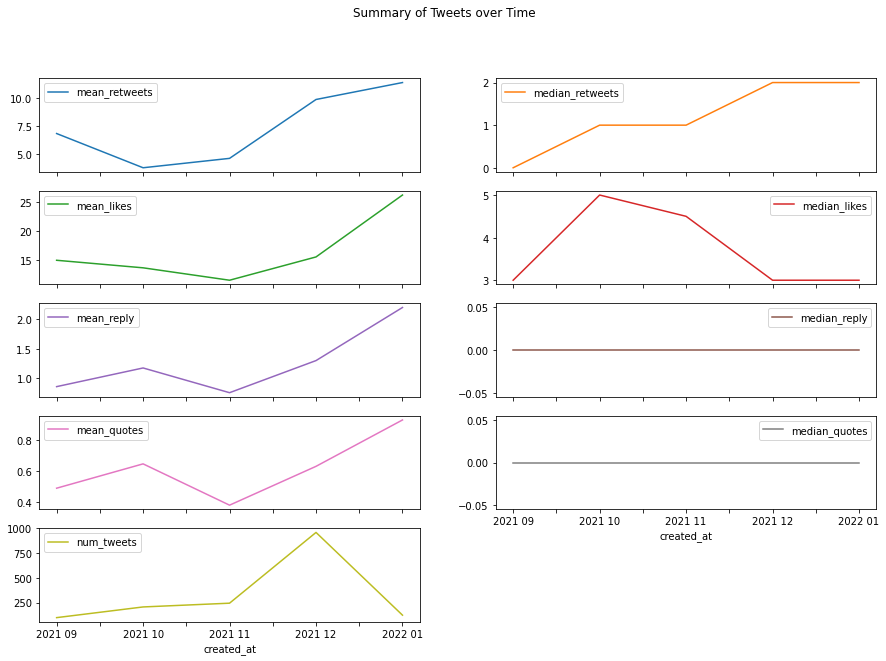

In [17]:
(
    clean_df
    .groupby([pd.to_datetime(clean_df.created_at).dt.strftime('%Y %m')])
    .agg(
        mean_retweets=('retweet_count', 'mean'), 
        median_retweets=('retweet_count', 'median'), 
        mean_likes=('like_count', 'mean'), 
        median_likes=('like_count', 'median'), 
        mean_reply=('reply_count', 'mean'), 
        median_reply=('reply_count', 'median'), 
        mean_quotes=('quote_count', 'mean'), 
        median_quotes=('quote_count', 'median'), 
        num_tweets=('retweet_count', 'count'),
        )
    .plot(subplots=True, title='Summary of Tweets over Time', layout=[5,2], figsize = (15, 10))
)